# Kalman Filter in R

An example of how a Kalman Filter can predict and adjust to a sequence (even with a given period or window).

@author Josep Ll. Berral (Barcelona Supercomputing Center)

#### Reference
* Based on: http://greg.czerniak.info/guides/kalman1/
* Also inspired by the case of use from: Knorn.F et al "Adaptive Kalman Filtering for Anomaly Detection in SW Appliances" http://www.hamilton.ie/florian/infocom2008.pdf

### Functions

* **kalman.filter** : Kalman Filter Function. Trains the filter and predicts it on the go

In [142]:
kalman.filter <- function (series, period = 1, qpar=0.00001, rpar = 0.1)
{
    if (period > 1)
    {
        Faux <- diag(1,nrow=(period-1));
        Faux <- cbind(0,Faux);
        Faux <- rbind(0,Faux);
        Faux[period,1] <- 1;
        F <- Faux;
    } else {
        F <- diag(1,nrow=1);
    }

    Q <- diag(qpar,nrow=period);
    R <- diag(rpar,nrow=period);
    P <- diag(1,nrow=period);
    S <- diag(1,nrow=period);
    H <- diag(1,nrow=period);
    I <- diag(1,nrow=period);
    V <- as.matrix(rep(1,period))

    v <- as.matrix(rep(0,period));
    s2 <- as.matrix(rep(0,period));
    x <- as.matrix(series[1:period]);

    alfa.v <- 0.1;
#   alfa.q <- 0.1;
    h <- function(value)
    {
        value[is.nan(value) | value < 0] <- 0;
        value;
    }

    retval <- matrix(0,4);

    for (i in 1:(length(series)/period))
    {
        # Make Prediction
        x.p <- F %*% x;
        P.p <- ((F %*% P) %*% t(F)) + Q;

        # Introducing Real Value of Y
        y <- as.matrix(series[((i-1)*period+1):(i*period)]);
        y.p <- H %*% x.p;
        e.p <- y - y.p;

        #y.p[1,1] <- y[1,1];
        retval <- cbind(retval,t(cbind(cbind(cbind(y,y.p),s2),e.p)));

        v <- (alfa.v * v) + ((1 - alfa.v) * h(e.p^2 - (((t(H) %*% P) %*% H) %*% V)));
        s2 <- (((t(H) %*% P) %*% H) %*% V) + v;

        # Update Values
        S <- (((H %*% P.p) %*% t(H)) + R);
        K <- (P.p %*% t(H)) / S; K[is.nan(K)] <- 0;
        x <- x.p + (K %*% e.p);
        P <- (I - K %*% H) %*% P.p;
#       Q <- (alfa.q * Q) + ((1 - alfa.q) * h((e.p^2 - (((((t(H) %*% F) %*% P) %*% t(F)) %*% H) + R)^2)/(H %*% t(H))));
    }

    retval[,-1];
}


* **ctflag**: Evaluates the outcome of the filter according to Sigmas (Flag the output as 0 = normal, 1= warning, 2 = error)

In [143]:
ctflag <- function (retval, threshold = 20, sigmas = 3)
{
    flags <- rep(0,ncol(retval));
    for (i in 1:ncol(retval))
    {
        observed <- retval[1,i];
        predicted <- retval[2,i];
        deviation <- sigmas * sqrt(retval[3,i]);
        error <- retval[4,i];

        if ((observed > predicted + deviation) || (observed < predicted - deviation))
        {
            flags[i] <- 2;
            if (error < threshold) flags[i] <- 1;
        } else {
            if (error > threshold) flags[i] <- 1;
        }
    }
    flags;
}

### Generate Series

We generate a new random serie to test the filter

In [144]:
generate_series <- function(size = 10)
{
    transition.matrix <- array(c(0.99,0.01,
                                 0.01,0.99),c(2,2));
    series <- NULL;
    last.state <- 1;
    for (i in 1:size)
    {
        jump.prob <- transition.matrix[last.state + 1,];
        new.state <- sample(c(0,1), 1, prob = jump.prob);
        series <- c(series, new.state);
        last.state <- new.state;
    }
    series;
    
}
series <- generate_series(1000);

### Evaluate Series

We simulate the arrival of inputs from our serie, and the evaluation the filter realizes

In [159]:
window <- 50;
plot.real <- series[1:(window - 1)];
plot.pred <- rep(0,(window - 1));
plot.flags <- rep(0,(window - 1));

for (i in window:length(series))
{
    aux <- kalman.filter(series[(i - window + 1):i], period = 5);
    rval <- aux[1,ncol(aux)];
    pval <- aux[2,ncol(aux)];

    flags <- ctflag(aux, threshold = 0.2, sigmas = 1);
    
    plot.real <- c(plot.real, rval);
    plot.pred <- c(plot.pred, pval);
    plot.flags  <- c(plot.flags, flags[length(flags)]);
}

code.flag <- rep("Normal",length(plot.flags));
code.flag[plot.flags == 1] <- "Warning";
code.flag[plot.flags == 2] <- "Error";

Also we plot the results

In [304]:
library(ggplot2)

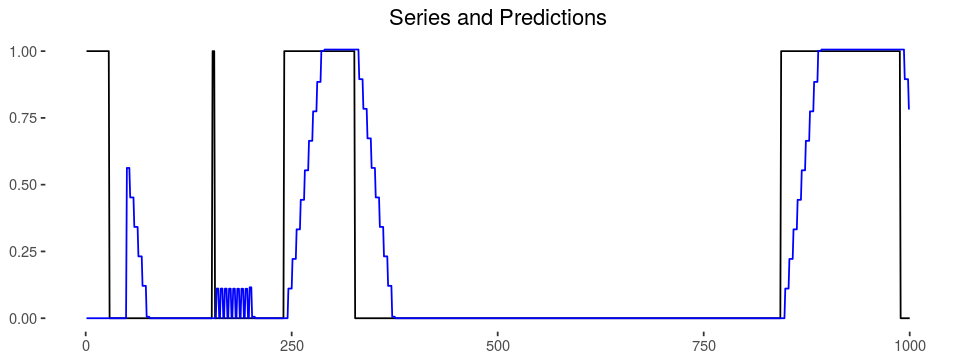

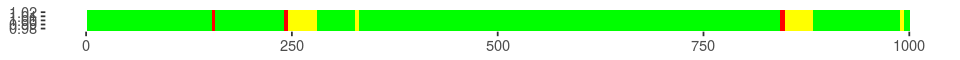

In [312]:
p1 <- ggplot(data = data.frame(plot.real, plot.pred, index=1:length(plot.real)), aes(index))  +
geom_line(aes(y = plot.real), color = "#000000") + 
geom_line(aes(y = plot.pred), color = "#0000FF") +
labs(x = NULL, y = NULL, title = "Series and Predictions") +
theme(panel.background = element_rect(fill = 'white'),legend.position = "none")

p2 <- ggplot(data = data.frame(plot.flags, 1:length(plot.flags)))  +
geom_tile(aes(y = 1, x = seq(1:length(plot.flags)), fill = code.flag, height = 0.05)) +
scale_fill_manual(values = c("#FF0000","#00FF00","#FFFF00")) +
labs(x = NULL, y = NULL, title = NULL) +
theme(panel.background = element_rect(fill = 'white'),legend.position = "none")

options(repr.plot.width=8, repr.plot.height=3);
p1
options(repr.plot.width=8, repr.plot.height=0.5);
p2